In [ ]:
!pip install roboflow
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from collections import Counter
from matplotlib import patches
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Dropout
from pycocotools.coco import COCO
from tensorflow.keras.utils import to_categorical

In [ ]:
# Mengunduh dataset menggunakan Roboflow API
rf = Roboflow(api_key="O2yMGJAWCYipgASp95jo")
project = rf.workspace("senam-otak").project("senam-otak")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Senam-Otak-3 in coco:: 100%|██████████| 1858/1858 [00:00<00:00, 2603.48it/s]


In [ ]:
# Direktori dataset
dataset_dir = "/content/Senam-Otak-3"

# Path ke file anotasi COCO untuk train, valid, dan test
train_annotation_file = os.path.join(dataset_dir, 'train/_annotations.coco.json')
valid_annotation_file = os.path.join(dataset_dir, 'valid/_annotations.coco.json')
test_annotation_file = os.path.join(dataset_dir, 'test/_annotations.coco.json')

EDA

In [ ]:
coco_annotation_file = os.path.join(dataset_dir, 'train/_annotations.coco.json')

if os.path.exists(coco_annotation_file):
    coco = COCO(coco_annotation_file)

    # Memuat kategori
    categories = coco.loadCats(coco.getCatIds())
    print("Kategori dalam anotasi COCO:")
    for category in categories:
        print(f"ID: {category['id']}, Nama: {category['name']}")
else:
    print(f"File anotasi tidak ditemukan: {coco_annotation_file}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Kategori dalam anotasi COCO:
ID: 0, Nama: exercise
ID: 1, Nama: back_slap
ID: 2, Nama: default
ID: 3, Nama: little_finger
ID: 4, Nama: peace
ID: 5, Nama: pistol
ID: 6, Nama: thumb_side


In [ ]:
def count_images_in_coco(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data.get('images', [])
    return len(images)

total_images = 0
for annotation_file in [train_annotation_file, valid_annotation_file, test_annotation_file]:
    if os.path.exists(annotation_file):
        num_images = count_images_in_coco(annotation_file)
        print(f"Jumlah gambar di {annotation_file}: {num_images}")
        total_images += num_images
    else:
        print(f"File anotasi tidak ditemukan: {annotation_file}")

print(f'Jumlah gambar dalam dataset COCO (train, valid, test): {total_images}')

Jumlah gambar di /content/Senam-Otak-3/train/_annotations.coco.json: 1300
Jumlah gambar di /content/Senam-Otak-3/valid/_annotations.coco.json: 369
Jumlah gambar di /content/Senam-Otak-3/test/_annotations.coco.json: 181
Jumlah gambar dalam dataset COCO (train, valid, test): 1850


Menampilkan contoh gambar beserta anotasi.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


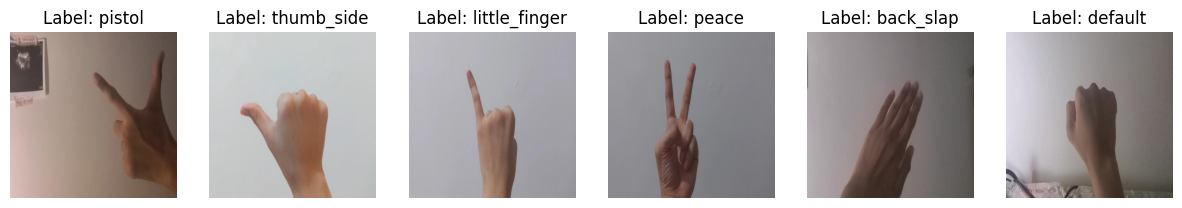

In [ ]:
def display_sample_images(image_paths, coco, num_samples=6):
    plt.figure(figsize=(15, 5))
    displayed_labels = set()
    displayed_count = 0

    random.shuffle(image_paths)

    for img_path in image_paths:
        if displayed_count >= num_samples:
            break

        img = plt.imread(img_path)
        img_filename = os.path.basename(img_path)

        # Mendapatkan ID gambar berdasarkan nama file
        img_ids = [img['id'] for img in coco.dataset['images'] if img['file_name'] == img_filename]

        if img_ids:
            img_id = img_ids[0]
            annotation_ids = coco.getAnnIds(imgIds=img_id)

            if annotation_ids:
                annotations = coco.loadAnns(annotation_ids)
                labels = {coco.loadCats(ann['category_id'])[0]['name'] for ann in annotations}

                if not labels - displayed_labels:
                    continue

                displayed_labels.update(labels)

                plt.subplot(1, num_samples, displayed_count + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Label: {', '.join(labels)}")
                displayed_count += 1
        else:
            continue

    plt.show()

# Memuat anotasi COCO
coco = COCO(coco_annotation_file)

image_dir = os.path.join(dataset_dir, 'train')
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

display_sample_images(image_paths, coco)

Grafik Distribusi Kategori

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


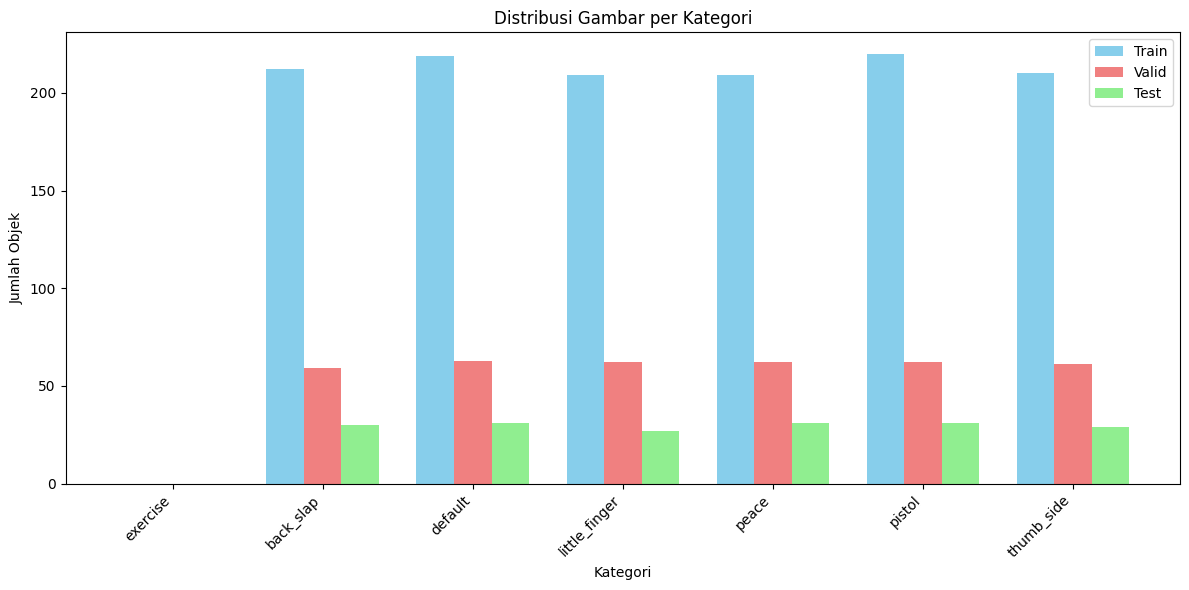

In [ ]:
def get_category_distribution(annotation_file):
    if os.path.exists(annotation_file):
        coco = COCO(annotation_file)
        annotation_ids = coco.getAnnIds()
        annotations = coco.loadAnns(annotation_ids)
        category_counts = Counter([ann['category_id'] for ann in annotations])

        category_names = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}
        return category_counts, category_names
    else:
        print(f"File anotasi tidak ditemukan: {annotation_file}")
        return None, None

train_category_counts, category_names = get_category_distribution(train_annotation_file)
valid_category_counts, _ = get_category_distribution(valid_annotation_file)
test_category_counts, _ = get_category_distribution(test_annotation_file)

category_ids = list(category_names.keys())
train_counts = [train_category_counts.get(cat_id, 0) for cat_id in category_ids]
valid_counts = [valid_category_counts.get(cat_id, 0) for cat_id in category_ids]
test_counts = [test_category_counts.get(cat_id, 0) for cat_id in category_ids]

plt.figure(figsize=(12, 6))
width = 0.25
x = range(len(category_ids))

plt.bar([i - width for i in x], train_counts, width=width, label='Train', color='skyblue')
plt.bar(x, valid_counts, width=width, label='Valid', color='lightcoral')
plt.bar([i + width for i in x], test_counts, width=width, label='Test', color='lightgreen')

plt.xticks(x, [category_names[cat_id] for cat_id in category_ids], rotation=45, ha='right')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Objek')
plt.title('Distribusi Gambar per Kategori')
plt.legend()
plt.tight_layout()
plt.show()

Distribusi Ukuran Bounding Box

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


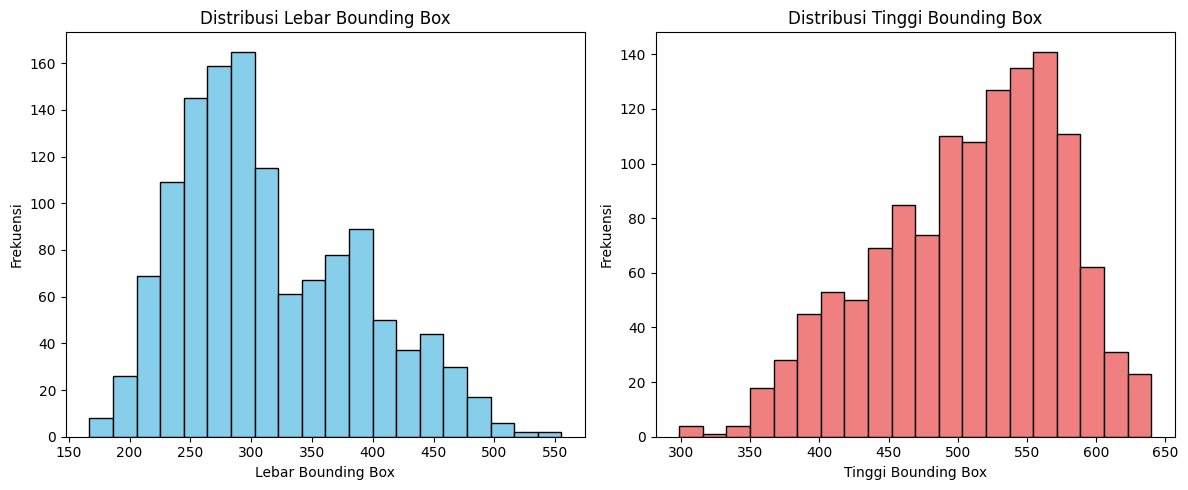

In [ ]:
coco = COCO(coco_annotation_file)
annotation_ids = coco.getAnnIds()
annotations = coco.loadAnns(annotation_ids)

bbox_sizes = [ann['bbox'][2:] for ann in annotations]
bbox_sizes = np.array(bbox_sizes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(bbox_sizes[:, 0], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Lebar Bounding Box')
plt.ylabel('Frekuensi')
plt.title('Distribusi Lebar Bounding Box')

plt.subplot(1, 2, 2)
plt.hist(bbox_sizes[:, 1], bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Tinggi Bounding Box')
plt.ylabel('Frekuensi')
plt.title('Distribusi Tinggi Bounding Box')

plt.tight_layout()
plt.show()


Visualisasi Contoh Anotasi

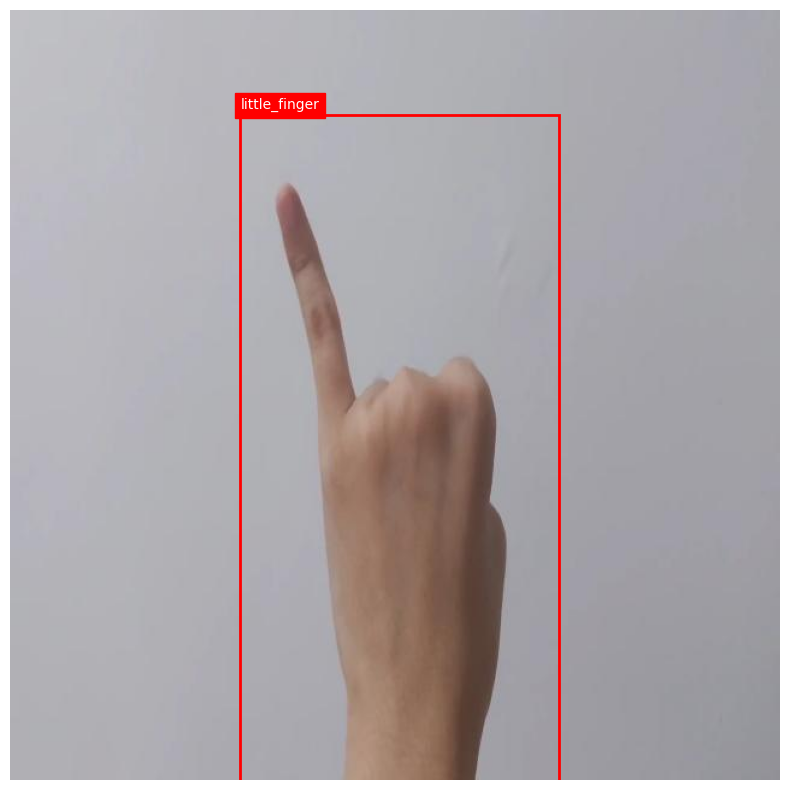

In [ ]:
def visualize_annotations(image_id, coco):
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(image_dir, img_info['file_name'])
    img = plt.imread(img_path)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    # Memuat anotasi
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        bbox = ann['bbox']
        category_name = coco.loadCats(ann['category_id'])[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 5, category_name, color='white',
                 backgroundcolor='red', fontsize=10)
    plt.axis('off')
    plt.show()

image_ids = coco.getImgIds()

random_image_id = random.choice(image_ids)

visualize_annotations(random_image_id, coco)

CNN - LSTM

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
x_train shape: (1279, 224, 224, 3), y_train shape: (1279,)
x_valid shape: (369, 224, 224, 3), y_valid shape: (369,)
Number of classes: 7
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 541ms/step - accuracy: 0.1972 - loss: 6.9469 - val_accuracy: 0.1707 - val_loss: 3.8931
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.2933 - loss: 3.4958 - val_accuracy: 0.5610 - val_loss: 2.2755
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 388ms/step - accuracy: 0.4630 - loss: 2.3705 - val_accuracy: 0.8401 - val_loss: 1.3522
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.6176 - loss: 1.7949 - val_accuracy: 0.9837 - val_loss: 0.9920
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.7218 - loss: 1.4513 - val_accuracy: 0.9837 - val_loss: 0.8271
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 382ms/step - accuracy: 0.7673 - loss: 1.3637 - val_accuracy: 0.9892 - val_loss: 0.7017
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.8411 - loss: 1.0899 - val_accuracy: 0.9892 - val_loss: 0.6205
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - accuracy: 0.8342 - loss: 1.0473 - val_accuracy: 1.000

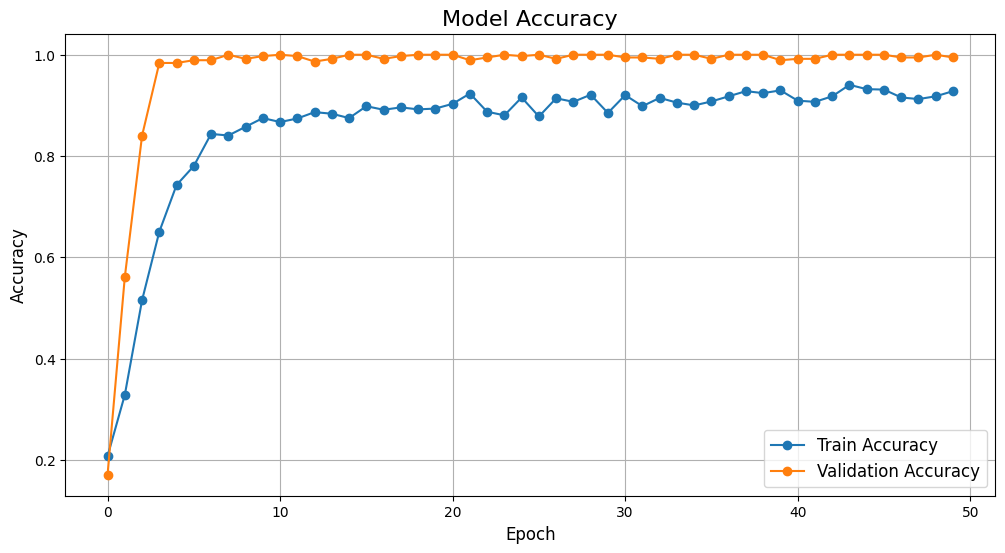

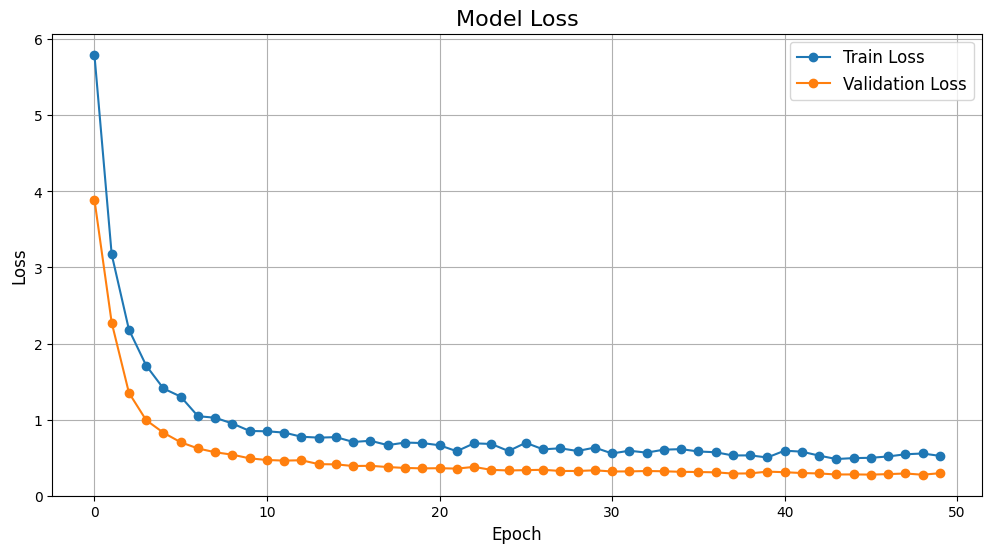

In [ ]:
# Path dataset
dataset_dir = "/content/Senam-Otak-3"
train_annotation_file = os.path.join(dataset_dir, 'train/_annotations.coco.json')
valid_annotation_file = os.path.join(dataset_dir, 'valid/_annotations.coco.json')

# Fungsi untuk memuat data COCO
def load_coco_data(annotation_file, image_dir, input_shape=(224, 224)):
    coco = COCO(annotation_file)
    images = []
    labels = []

    for img_id in coco.imgs:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_info['file_name'])

        if not os.path.exists(img_path):
            continue

        # Memuat gambar
        img = cv2.imread(img_path)
        img = cv2.resize(img, input_shape)
        img = img / 255.0  # Normalisasi

        # Label (kategori pertama dari anotasi untuk kesederhanaan)
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        if anns:
            label = anns[0]['category_id']
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load train dan validasi data
input_shape = (224, 224)
x_train, y_train = load_coco_data(train_annotation_file, os.path.join(dataset_dir, 'train'), input_shape)
x_valid, y_valid = load_coco_data(valid_annotation_file, os.path.join(dataset_dir, 'valid'), input_shape)

# Debug untuk memastikan data sudah benar
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

num_classes = max(np.max(y_train), np.max(y_valid)) + 1
print(f"Number of classes: {num_classes}")

# Konversi label ke one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

# Augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(x_train)

# Generator untuk training
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# Model CNN-LSTM
def create_model(input_shape, num_classes):
    cnn_base = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(*input_shape, 3))
    cnn_base.trainable = False

    model = models.Sequential([
        cnn_base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.RepeatVector(10),
        layers.LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),
        layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.01))
    ])

    return model

# Compile model
model = create_model(input_shape, num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Training model
history = model.fit(
    train_generator,
    validation_data=(x_valid, y_valid),
    epochs=50,
)

model.save("cnn_lstm_model.h5")

# Visualisasi grafik akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

# Visualisasi grafik loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 2. Optimisasi
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=10,
    batch_size=32,
    callbacks=[reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.9596 - loss: 0.3916 - val_accuracy: 0.9946 - val_loss: 0.2720 - learning_rate: 0.0010
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9648 - loss: 0.3958 - val_accuracy: 1.0000 - val_loss: 0.2498 - learning_rate: 0.0010
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9704 - loss: 0.3478 - val_accuracy: 1.0000 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.9760 - loss: 0.3330 - val_accuracy: 0.9810 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.9604 - loss: 0.3769 - val_accuracy: 0.9973 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9761 - loss: 0.3133
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.9757 - loss: 0.314

In [ ]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

val_loss = np.mean(val_loss)
val_accuracy = np.mean(val_accuracy)

# Menampilkan rata-rata hasil validasi
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Validation Loss: 0.24451033324003218
Validation Accuracy: 0.9962059617042541


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        63
           3       1.00      1.00      1.00        62
           4       1.00      1.00      1.00        62
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        61

    accuracy                           1.00       369
   macro avg       1.00      1.00      1.00       369
weighted avg       1.00      1.00      1.00       369



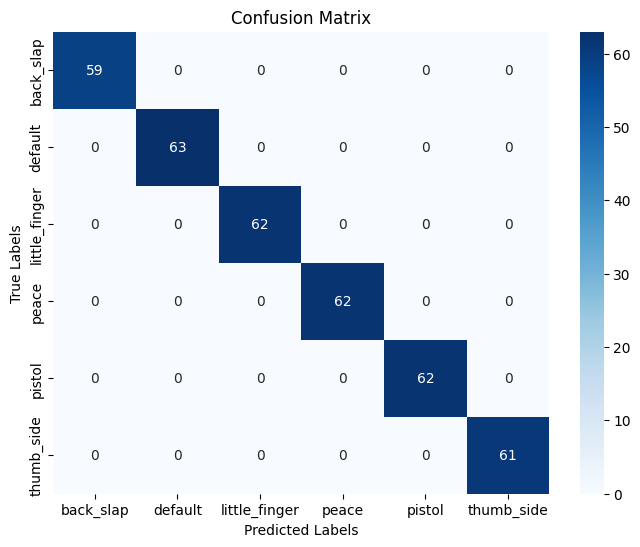

In [ ]:
# Memuat kategori dari file COCO
coco_annotation_file = os.path.join(dataset_dir, 'train/_annotations.coco.json')

if os.path.exists(coco_annotation_file):
    coco = COCO(coco_annotation_file)

    # Memuat kategori
    categories = coco.loadCats(coco.getCatIds())

    # Filter kategori dengan ID != 0
    categories_filtered = [category for category in categories if category['id'] != 0]
    class_names = [category['name'] for category in categories_filtered]

y_pred = model.predict(x_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

valid_indices = np.where(y_true != 0)
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred_classes[valid_indices]

print("Classification Report:\n", classification_report(y_true_filtered, y_pred_filtered))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)

# Plot confusion matrix dengan nama kelas dari COCO
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


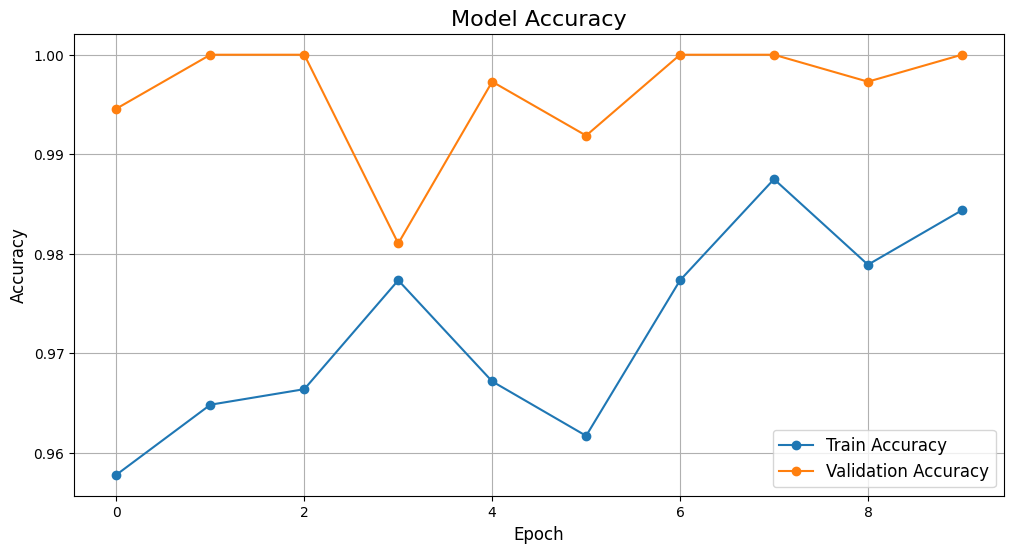

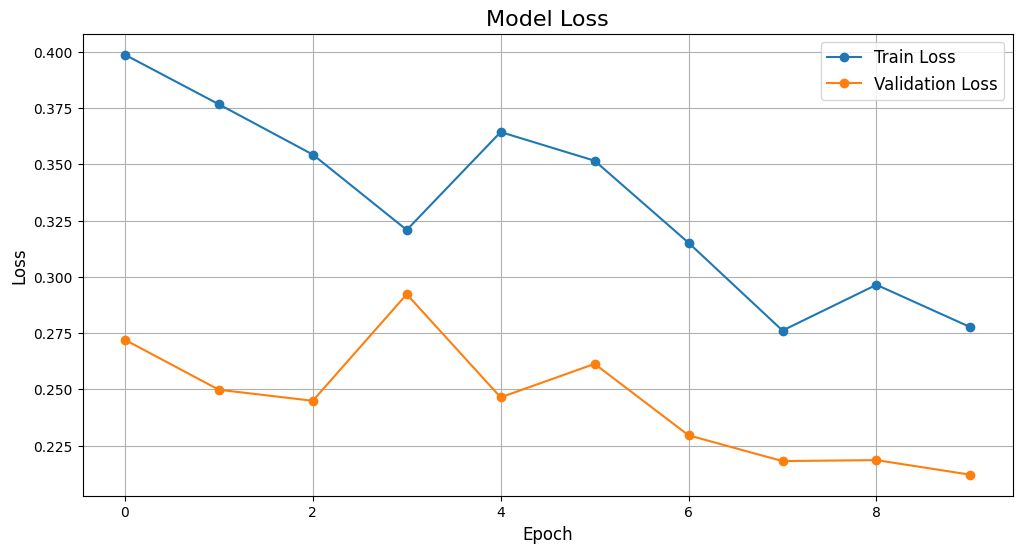

In [ ]:
# Visualisasi grafik akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

# Visualisasi grafik loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()
